# ***CASE STUDY:***

---
This is for the demonstration purpose of using the trained neural network to fit the Generalized Extreme Value (GEV) distribution to univariate extremes and estimate the parameters quickly.

In [1]:
## -- Required packages --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy
import math
import statistics
from numpy import random
from scipy.stats import genextreme as gev

import tensorflow as tf
from tensorflow import reduce_mean, square
import tensorflow.keras as keras
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Input, Dense, Dropout
import time
import pickle

import os
import urllib.request

In [2]:
## Connecting with my googlle drive to call the trained neural model, one could call the directory where they save the trained
!git clone https://github.com/Sweta-AMS/Paper-Fast-parameter-estimation-of-Generalized-Extreme-Value-distribution-using-Neural-Networks.git

Cloning into 'Paper-Fast-parameter-estimation-of-Generalized-Extreme-Value-distribution-using-Neural-Networks'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 123 (delta 6), reused 3 (delta 3), pack-reused 111
Receiving objects: 100% (123/123), 4.13 MiB | 27.43 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [3]:
pip install pyyaml h5py  # package required to call the trained models in HDF5 format

In [4]:
## -- Defining Percentile Set for extracting summary statisics to evaluate the model --
# selected quantiles/percentiles mainly focus on the tail of the distribution, Q1, Q2,and Q3
p_set= np.array([0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 0.9999])
print(p_set.shape)

(11,)


***Note***

---
This is an example of calling the trained neural model directly from the GitHub repository.

In [5]:
## -- Calling the trained Neural Model --:
loaded_model = keras.models.load_model('/content/Paper-Fast-parameter-estimation-of-Generalized-Extreme-Value-distribution-using-Neural-Networks/Code/my_trained_model-NN-latest.h5')

## Summary of the loaded model
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputlayer (InputLayer)     [(None, 11)]              0         
                                                                 
 layer1 (Dense)              (None, 512)               6144      
                                                                 
 layer2 (Dense)              (None, 512)               262656    
                                                                 
 layer3 (Dense)              (None, 512)               262656    
                                                                 
 layer4 (Dense)              (None, 128)               65664     
                                                                 
 layer5 (Dense)              (None, 128)               16512     
                                                                 
 outputlayer (Dense)         (None, 3)                 387   

In [6]:
## -- Package required to load the case study dataset --
!pip install netCDF4
import netCDF4 as nc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00


***Note***

---

We cannot share the case study with the public at the moment, but if you would like to access it, please shoot us an email at *srai@mines.edu*. One could follow the code to reproduce the results and estimate the GEV parameters.

## <span style='font-family:Times New Roman'> CO2 289 ppm level

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
maxtemp_dataset_CO2L289 ='/content/drive/My Drive/Data storage - Paper 1/CaseStudy-Data&Results/1870_long2_last1000y_combine_TREFHTMX_US_only.nc'
maxtemp_dataset_CO2L289 = nc.Dataset(maxtemp_dataset_CO2L289)

lat_L289 = maxtemp_dataset_CO2L289.variables['lat'][:]
lon_L289 = maxtemp_dataset_CO2L289.variables['lon'][:]

In [9]:
print(len(lat_L289))
print(len(lon_L289))

7
19


In [10]:
daily_max_temp_L289_K = maxtemp_dataset_CO2L289.variables['TREFHTMX'][:] # temperature measured in Kelvin
print(np.shape(daily_max_temp_L289_K))

daily_max_temp_L289_C = daily_max_temp_L289_K-273.15

time_L289 = maxtemp_dataset_CO2L289.variables['time'][:] # dates as we are dealing with daily data
time_band_L289 = maxtemp_dataset_CO2L289.variables['time_bnds'][:]

(365000, 7, 19)


In [11]:
## Extract Maximum temperature over the year
annual_maxL289 = np.empty((len(lat_L289), len(lon_L289), 1000))

for i in range(len(lat_L289)):
  for j in range(len(lon_L289)):
    ## list to store the maximum annual temperature over 1000-yr
    temp = []
    ## lower limit
    a = 0
    ## upper limit
    b = 365

    ## 1000 year time run
    for t in range(1000):
      temp.append(np.max(daily_max_temp_L289_C[range(a, b), i, j]))
      ## Updating the bounds
      if t<999:
        a = int(b)
        b = int(b+365)

    annual_maxL289[i, j, :] = temp

In [12]:
## Standardized the values along with extracting the quantiles
CS_Percentile_MatL289 = np.empty((len(lat_L289), len(lon_L289), len(p_set)))
CS_MedianL289 = np.empty((len(lat_L289), len(lon_L289)))
CS_IQRL289 = np.empty((len(lat_L289), len(lon_L289)))

std_Data_minL289 = np.empty((len(lat_L289), len(lon_L289)))
std_Data_maxL289 = np.empty((len(lat_L289), len(lon_L289)))

for i in range(len(lat_L289)):
  for j in range(len(lon_L289)):
    ## Summary
    data_ = annual_maxL289[i, j, :]

    median_ = statistics.median(data_)
    IQR_ = scipy.stats.iqr(data_)

    ## Storing: Median & IQR
    CS_MedianL289[i, j]= median_
    CS_IQRL289[i, j]= IQR_

    ## Standardization of sample
    std_Data = (data_- median_)/IQR_

    std_Data_minL289[i,j] = np.min(std_Data)
    std_Data_maxL289[i,j] = np.max(std_Data)

    ## Extracting percentile values
    CS_Percentile_MatL289[i, j, :] = np.percentile(std_Data, p_set*np.array(100))

In [13]:
# -- PARAMETER ESTIMATION USING NEURAL NETWORK --
# Prediction over the Case Study
store_pred_CSL289 = np.empty((len(lat_L289), len(lon_L289), 3))

# record time
start_time = time.time()
for i in range(len(lat_L289)):
  for j in range(len(lon_L289)):
    # Predicted Location, Scale, Shape parameters
    store_pred_CSL289[i, j, :] = loaded_model.predict(np.reshape(CS_Percentile_MatL289[i, j, :], (1,-1)))

print("--- %s seconds ---" % (time.time()-start_time))
time_NN = (time.time()-start_time)

1/1 [==============================] - 0s 20ms/step
--- 15.33420991897583 seconds ---


In [14]:
## -- Location, Scale, and Shape predictions
cs_scaled_loc_pred_valsL289 = store_pred_CSL289[:, :, 0]
cs_delta_pred_valsL289 = store_pred_CSL289[:, :, 1]


## Converting delta to sc_scale
mch_epsilon = np.finfo(float).eps
is_weibull = store_pred_CSL289[:, :, 2]  > mch_epsilon

## For frechet
sc_scale_frechet_pred_valsL289 = (store_pred_CSL289[:, :, 2]*(std_Data_minL289 - cs_delta_pred_valsL289 )) + np.exp(cs_delta_pred_valsL289 )

## For weibull
sc_scale_weibull_pred_valsL289 = (store_pred_CSL289[:, :, 2] *(std_Data_maxL289 - cs_delta_pred_valsL289 )) + np.exp(cs_delta_pred_valsL289)

## Estimate of the transformed scale parameter
cs_scaled_scale_pred_valsL289 = np.where(is_weibull, sc_scale_weibull_pred_valsL289, sc_scale_frechet_pred_valsL289)

In [15]:
## -- Location, Scale, and Shape predictions --:
## -- Back-transformed Location, Scale parameter
## Transforming back to original form of location and scale parameter values
CS_Loc_predL289 = (cs_scaled_loc_pred_valsL289*np.array(CS_IQRL289)) + np.array(CS_MedianL289)
CS_Scale_predL289 = cs_scaled_scale_pred_valsL289*np.array(CS_IQRL289)
CS_Shape_predL289 = -store_pred_CSL289[:, :, 2]

In [16]:
## -- Calculating the return values across different return periods --:
return_vals20_estL289= gev.isf(1/20,
                             CS_Shape_predL289,
                             CS_Loc_predL289,
                             CS_Scale_predL289)
return_vals50_estL289= gev.isf(1/50,
                             CS_Shape_predL289,
                             CS_Loc_predL289,
                             CS_Scale_predL289)
return_vals1000_estL289= gev.isf(1/1000,
                             CS_Shape_predL289,
                             CS_Loc_predL289,
                             CS_Scale_predL289)

### Case study: L289 Predicted Shape

In [73]:
fn = 'CS_L289.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')
lat = ds.createDimension('lat', len(lat_L289))
lon = ds.createDimension('lon', len(lon_L289))

latsL289 = ds.createVariable('lat', 'f4', ('lat',))
lonsL289 = ds.createVariable('lon', 'f4', ('lon',))

CS_ShapeL289 = ds.createVariable('CS_Shape', 'f4', ('lat', 'lon',))
CS_ShapeL289.units = 'Unknown'

CS_ScaleL289 = ds.createVariable('CS_Scale', 'f4', ('lat', 'lon',))
CS_ScaleL289.units = 'Unknown'

CS_LocL289 = ds.createVariable('CS_Loc', 'f4', ('lat', 'lon',))
CS_LocL289.units = 'Unknown'

returnL20 = ds.createVariable('Return_L20', 'f4', ('lat', 'lon',))
returnL20.units = 'Unknown'

returnL50 = ds.createVariable('Return_L50', 'f4', ('lat', 'lon',))
returnL50.units = 'Unknown'

returnL1000  = ds.createVariable('Return_L1000', 'f4', ('lat', 'lon',))
returnL1000.units = 'Unknown'

latsL289[:] = lat_L289
lonsL289[:] = lon_L289

CS_ShapeL289[ :, :] =  CS_Shape_predL289 # CS_Shape_predL289 # mind you this is c
CS_ScaleL289[ :, :] = CS_Scale_predL289
CS_LocL289[ :, :] = CS_Loc_predL289

returnL20[ :, :] = return_vals20_estL289
returnL50[ :, :] = return_vals50_estL289
returnL1000[ :, :] = return_vals1000_estL289
ds.close()

In [74]:
# ## SAVE NETCDF File:
# CS_L289 ='CS_L289.nc'
CS_Pred_L289 = nc.Dataset(CS_L289)

In [25]:
!pip install cartopy

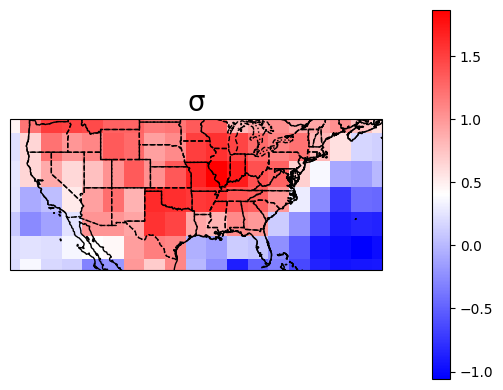

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Assuming CS_Pred_L289 is a netCDF variable
lons = CS_Pred_L289.variables['lon'][:]
lats = CS_Pred_L289.variables['lat'][:]

# Create a Cartopy projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Mercator()})
ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())

# Plot the data
c_scheme = ax.pcolormesh(lons, lats, np.log(CS_Pred_L289.variables['CS_Scale']), cmap='bwr', transform=ccrs.PlateCarree())

# Draw coastlines and states
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--')

# Add colorbar
cbar = plt.colorbar(c_scheme, location='right', pad=0.1)

# Set title
plt.title(chr(963), fontsize=20)

# Show the plot
plt.show()

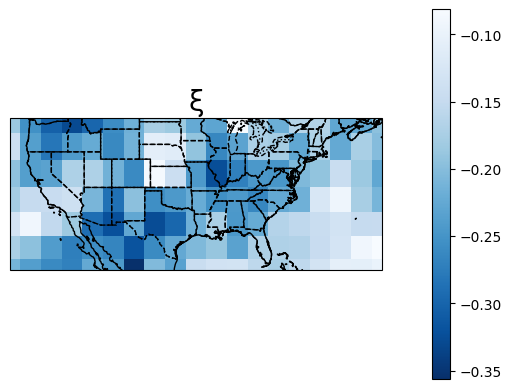

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Assuming CS_Pred_L289 is a netCDF variable or similar
lons = CS_Pred_L289.variables['lon'][:]
lats = CS_Pred_L289.variables['lat'][:]

## Create a Cartopy projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Mercator()})
ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())

# Plot the data with reversed white-to-blue color map
c_scheme = ax.pcolormesh(lons, lats, CS_Pred_L289.variables['CS_Shape'], cmap='Blues_r', transform=ccrs.PlateCarree())

# Draw coastlines and states
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--')

# Add colorbar
cbar = plt.colorbar(c_scheme, location='right', pad=0.1)

# Set title
plt.title(chr(958), fontsize=20) # (956) this is for mu

# Show the plot
plt.show()

In [78]:
# -- Generating sample for Bootstrap Sample to avoid looping -- #
# Function to compute the Percentile matrix for the standardized data
def boot_Z_quantiles(seed, shape, loc, scale, p_vec, N, B):
    """
    Function to return 'Quantile matrix' for different simulated sample over same parameter
    Arguments:
    * seed = set seed to generate a fix set of random sample from GEV distribution
    * shape, loc, scale_vec = simulated shape, location, scale parameter value
      -> REQUIRED to generate GEV
      -> ALSO RESPONSE VARIABLE!

    * p_vec = quantile set
    * N = GEV sample generated for each parameter combination
      -> is set to 100 for now.
    * B = no of bootstrap repeatations
    """
    # setting the seed for sample generation
    random.seed(seed)

    # -- initializing the matrices & vectors --
    percentile_Matrix = np.empty((B,len(p_vec)))# store the counts
    storeIqr = [] # store sample IQR
    storeMedian = [] # store sample MEDIAN

    storeZmin = [] # store sample MEDIAN
    storeZmax = [] # store sample MEDIAN

    # -- extracting counts --
    for i in range(B):

        # sample generation
        X_sample = gev.rvs(c=shape,
                           loc=loc,
                           scale=scale,
                           size=N)
        #print(X_sample)
        # computing sample Median and IQR
        Median_sample = np.median(X_sample)
        Iqr_sample = scipy.stats.iqr(X_sample)

        storeMedian.append(Median_sample)
        storeIqr.append(Iqr_sample)

        # standardization of the data
        Z_sample = (X_sample-Median_sample)/Iqr_sample
        storeZmin.append(np.min(Z_sample))
        storeZmax.append(np.max(Z_sample))

        percentile_Matrix[i,:] = np.percentile(Z_sample, p_vec*np.array(100))

    return percentile_Matrix, np.array(storeMedian), np.array(storeIqr), np.array(storeZmin), np.array(storeZmax)

In [80]:
B= 1000
N= 1000
boot_est = np.empty((len(lat_L289), len(lon_L289), 3))
boot_return = np.empty((len(lat_L289), len(lon_L289), 3))
boot_sd= np.empty((len(lat_L289), len(lon_L289), 3))
boot_return_sd= np.empty((len(lat_L289), len(lon_L289), 3))

# record time
start_time= time.time()
for i in range(len(lat_L289)):
  for j in range(len(lon_L289)):
    # -- Bootstrap --
    # -- Computing the Percentile Matrix for Bootstrap --
    percentileMatBoot, sampleMediansBoot, sampleIQRsBoot, sampleZminsBoot, sampleZmaxsBoot= boot_Z_quantiles(seed= i+j,
                                                                                                             shape=-CS_Shape_predL289[i,j],
                                                                                                             loc=CS_Loc_predL289[i,j],
                                                                                                             scale=CS_Scale_predL289[i,j],
                                                                                                             p_vec=p_set,
                                                                                                             N=N,
                                                                                                             B=B)
    # Bootstrap Estimates
    fitted_vals_boot= loaded_model.predict(percentileMatBoot) # dimension (Bx11)

    # scaled estimates of Loc-Scale parameters
    sc_loc_pred_vals_boot= fitted_vals_boot[:,0] # dimension (Bx1)
    delta_pred_vals_boot= fitted_vals_boot[:,1] # dimension (Bx1)
    shape_pred_vals_boot= fitted_vals_boot[:,2]  # dimension (Bx1)


    # Converting delta_pred_vals1000 to sc_scale_pred_vals1000
    is_weibull_pred_boot = shape_pred_vals_boot > mch_epsilon

    # for frechet
    sc_scale_frechet_pred_boot = (shape_pred_vals_boot*(sampleZminsBoot - sc_loc_pred_vals_boot)) + np.exp(delta_pred_vals_boot)

    # for weibull
    sc_scale_weibull_pred_boot = (shape_pred_vals_boot*(sampleZmaxsBoot - sc_loc_pred_vals_boot)) + np.exp(delta_pred_vals_boot)

    # Estimate of the transformed scale parameter
    sc_scale_pred_vals_boot = np.where(is_weibull_pred_boot, sc_scale_weibull_pred_boot, sc_scale_frechet_pred_boot)



    # Back-transformed Loc-Scale parameters
    loc_pred_vals_boot= (sc_loc_pred_vals_boot*sampleIQRsBoot)+ sampleMediansBoot # dimension (Bx1)
    scale_pred_vals_boot= sc_scale_pred_vals_boot*sampleIQRsBoot # dimension (Bx1)


    return_pred_vals20_boot= gev.isf(1/20,
                                     shape_pred_vals_boot,
                                     loc_pred_vals_boot,
                                     scale_pred_vals_boot)
    return_pred_vals50_boot= gev.isf(1/50,
                                     shape_pred_vals_boot,
                                     loc_pred_vals_boot,
                                     scale_pred_vals_boot)
    return_pred_vals1000_boot= gev.isf(1/1000,
                                      shape_pred_vals_boot,
                                      loc_pred_vals_boot,
                                      scale_pred_vals_boot)

    # storing bootstrap estimates
    boot_est[i,j, ]= [np.mean(loc_pred_vals_boot), np.mean(scale_pred_vals_boot), np.mean(shape_pred_vals_boot)]
    boot_return[i,j, ]= [np.mean(return_pred_vals20_boot), np.mean(return_pred_vals50_boot), np.mean(return_pred_vals1000_boot)]

    # storing bootstrap standard deviation
    boot_sd[i,j, ]= [np.std(loc_pred_vals_boot), np.std(scale_pred_vals_boot), np.std(shape_pred_vals_boot) ]
    boot_return_sd[i,j, ]= [np.std(return_pred_vals20_boot), np.std(return_pred_vals50_boot), np.std(return_pred_vals1000_boot)]

print("--- %s seconds ---" % (time.time()-start_time))
tot_time= (time.time()-start_time)

32/32 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:3053: RuntimeWarning:

divide by zero encountered in divide



32/32 [==============================] - 0s 3ms/step
--- 191.91787242889404 seconds ---
